### Homework: 6

#### 1.	Evaluate text similarity of Amazon book search results by doing the following:

***Do a book search on Amazon. Manually copy the full book title (including subtitle) of each of the top 24 books listed in the first two pages of search results.***



In [3]:
# import libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import string
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import requests

%matplotlib inline
pd.options.display.max_colwidth=500

In [16]:
# define our helper functions:
# tokenize text
def tokenize_text(book_text):
    TOKEN_PATTERN = r'\s+'
    regex_wt = nltk.RegexpTokenizer(pattern=TOKEN_PATTERN, gaps=True)
    word_tokens = regex_wt.tokenize(book_text)
    return word_tokens

# remove characters after tokenization
def remove_characters_after_tokenization(tokens):
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub('', token) for token in tokens])
    return filtered_tokens

# convert tokens to lowercase
def convert_to_lowercase(tokens):
    return [token.lower() for token in tokens if token.isalpha()]

# remove token stopwords
def remove_stopwords(tokens):
    stopword_list = nltk.corpus.stopwords.words('english')
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    return filtered_tokens

# apply lemmatization to tokens
def apply_lemmatization(tokens, wnl=WordNetLemmatizer()):
    return [wnl.lemmatize(token) for token in tokens]

# clean the text book lists by performing tokenization, text clean up
# and lemmatization
def cleanTextBooks(book_texts):
    clean_books = []
    for book in book_texts:
        book_i = tokenize_text(book)
        book_i = remove_characters_after_tokenization(book_i)
        book_i = convert_to_lowercase(book_i)
        book_i = remove_stopwords(book_i)
        book_i = apply_lemmatization(book_i)
        clean_books.append(book_i)
    return clean_books

# plot a heat map of the cosine similarity
def plot_heatmap(df_hm, xlabels, ylabels):
    sns.set(style="white")

    # Set up the matplotlib figure
    # (to enlarge the cells, increase the figure size)
    f, ax = plt.subplots(figsize=(18, 18))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(df_hm, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df_hm, mask=mask, cmap=cmap, center=0.5,
            xticklabels=xlabels, yticklabels=ylabels,
            square=True, linewidths=.5, fmt='.2f',
            annot=True, cbar_kws={"shrink": .5}, vmax=1)

    ax.set_title("Heatmap of cosine similarity scores").set_fontsize(15)
    ax.set_xlabel("")
    ax.set_ylabel("")

    return ax

# compute the cosine similarity of the pairwise comparisons
def compute_cosine_similarity(pair):

    # extract the indexes from the pair
    book1, book2 = pair

    # split on _ and get index
    book1_index = int(book1.split("_")[1])
    book2_index = int(book2.split("_")[1])

    # get the feature matrix of the document
    book1_fm = feature_matrix.toarray()[book1_index]
    book2_fm = feature_matrix.toarray()[book2_index]

    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(book1_fm, book2_fm)

    return manual_cosine_similarity

def unique_params(parameter_search):
    '''
    Returns a unique combination of parameter combinations to loop through in
    the grid search routine
    '''
    all_keys = sorted(parameter_search)
    combinations = it.product(*(parameter_search[key] for key in all_keys))
    combinations = [
        dict(zip(sorted(parameter_search.keys()), params))
        for params in combinations
    ]
    return list(combinations)

In [4]:
books = requests.get('https://www.amazon.com/s?k=Richard+Feynman&i=stripbooks&ref=nb_sb_noss_2', verify=False)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/urllib3/connectionpool.py:986: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.amazon.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [5]:
from bs4 import BeautifulSoup

In [6]:
soup = BeautifulSoup(books.text)

In [7]:
soup

<!--
        To discuss automated access to Amazon data please contact api-services-support@amazon.com.
        For information about migrating to our APIs refer to our Marketplace APIs at https://developer.amazonservices.com/ref=rm_5_sv, or our Product Advertising API at https://affiliate-program.amazon.com/gp/advertising/api/detail/main.html/ref=rm_5_ac for advertising use cases.
--><!DOCTYPE html>
<html>
<head>
<meta charset="utf-8"/>
<meta content="ie=edge" http-equiv="x-ua-compatible"/>
<meta content="width=device-width, initial-scale=1, shrink-to-fit=no" name="viewport"/>
<title>Sorry! Something went wrong!</title>
<style>
  html, body {
    padding: 0;
    margin: 0
  }

  img {
    border: 0
  }

  #a {
    background: #232f3e;
    padding: 11px 11px 11px 192px
  }

  #b {
    position: absolute;
    left: 22px;
    top: 12px
  }

  #c {
    position: relative;
    max-width: 800px;
    padding: 0 40px 0 0
  }

  #e, #f {
    height: 35px;
    border: 0;
    font-size: 1em
  }


***Unfortunately, ammazon doesn't allow programmatic access to their data for free :(***



In [13]:
#search string = Richard Feynman
book_titles = [
    'The Grand Biocentric Design: How Life Creates Reality',
    "Surely You're Joking, Mr. Feynman!: Adventures of a Curious Character",
    'Six Easy Pieces: Essentials of Physics Explained by Its Most Brilliant Teacher',
    'The Feynman Lectures on Physics, boxed set: The New Millennium Edition',
    'The Pleasure of Finding Things Out: The Best Short Works of Richard P. Feynman (Helix Books)',
    '"What Do You Care What Other People Think?": Further Adventures of a Curious Character',
    'The Meaning of It All: Thoughts of a Citizen-Scientist',
    'Genius: The Life and Science of Richard Feynman',
    'Six Not-So-Easy Pieces: Einstein s Relativity, Symmetry, and Space-Time',
    'Darwin in a New Key: Evolution and the Question of Value',
    'Quantum Mechanics: A Modern Development (2Nd Edition)',
    'QED: The Strange Theory of Light and Matter (Princeton Science Library)',
    'Perfectly Reasonable Deviations from the Beaten Track',
    'The Feynman Lectures on Physics, Vol. I: The New Millennium Edition: Mainly Mechanics, Radiation, and Heat (Volume 1)',
    'The Feynman Lectures on Physics - Vol. I, II & III Bundle',
    'The Character of Physical Law, with new foreword (The MIT Press)',
    "Feynman's Tips on Physics: Reflections, Advice, Insights, Practice - A Problem-Solving Supplement to the Feynman Lectures on Physics",
    'Exercises for the Feynman Lectures on Physics',
    'Quantum Mechanics and Path Integrals: Emended Edition (Dover Books on Physics)',
    'Relativity: The Special and General Theory (Dover Books on Physics)',
    'Quantum Mechanics: Basic & Advanced Concepts for Beginners',
    'The Code Breaker: Jennifer Doudna, Gene Editing, and the Future of the Human Race',
    'No-Nonsense Electrodynamics: A Student Friendly Introduction',
    "Quantum Man: Richard Feynman's Life in Science (Great Discoveries)",
    "Don't You Have Time to Think?"
]

In [14]:
len(book_titles)

25

***In Python, run one of the text-similarity measures covered in this course, e.g., cosine similarity. Compare each of the book titles, pairwise, to every other one.***




In [24]:
# build generic listing of books so we can build out a titles
bookids_vals = ["book_" + str(i) for i in range(len(book_titles))]

# create a dictionary of the values
book_dict = dict(zip(bookids_vals, book_titles))

# grab all of the ids in the list so we can do pairwise comparison
book_ids = list(book_dict.keys())

# create a listing of all possible pairs
# we want to filter out any self-compares and any duplicate comparisons
book_pairs = []

for i, v in enumerate(book_ids):
    for j in book_ids[i+1:]:
        book_pairs.append((book_ids[i],j))

# Look at our book pairs to see if they make sense
print("Total book pairs: ", str(len(book_pairs)))
print("FIrst 10 pairs: ", book_pairs[:10])


Total book pairs:  300
FIrst 10 pairs:  [('book_0', 'book_1'), ('book_0', 'book_2'), ('book_0', 'book_3'), ('book_0', 'book_4'), ('book_0', 'book_5'), ('book_0', 'book_6'), ('book_0', 'book_7'), ('book_0', 'book_8'), ('book_0', 'book_9'), ('book_0', 'book_10')]


In [25]:
# clean the list of book to make them consistent
# cleanTextBooks returns a list of lists
clean_books = cleanTextBooks(book_titles)

# convert the list of lists to a list of strings
norm_clean_books = [' '.join(text) for text in clean_books]

print(norm_clean_books)

['grand biocentric design life creates reality', 'surely youre joking mr feynman adventure curious character', 'six easy piece essential physic explained brilliant teacher', 'feynman lecture physic boxed set new millennium edition', 'pleasure finding thing best short work richard p feynman helix book', 'care people think adventure curious character', 'meaning thought citizenscientist', 'genius life science richard feynman', 'six notsoeasy piece einstein relativity symmetry spacetime', 'darwin new key evolution question value', 'quantum mechanic modern development edition', 'qed strange theory light matter princeton science library', 'perfectly reasonable deviation beaten track', 'feynman lecture physic vol new millennium edition mainly mechanic radiation heat volume', 'feynman lecture physic vol ii iii bundle', 'character physical law new foreword mit press', 'feynman tip physic reflection advice insight practice problemsolving supplement feynman lecture physic', 'exercise feynman lect

In [26]:
vectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,1))

# calculate the feature matrix
feature_matrix = vectorizer.fit_transform(norm_clean_books).astype(float)

# display the shape of feature matrix
display(feature_matrix.shape)

# display the first feature vector
display(feature_matrix[0])

# display the dense version of the feature vector
display(feature_matrix.toarray()[0])

# display the shape of dense feature vector
display(feature_matrix.toarray()[0].shape)

# display the first document text
display(norm_clean_books[0])

(25, 121)

<1x121 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.42074276, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.42074276, 0.        ,
       0.        , 0.42074276, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.42074276, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.33893608, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

(121,)

'grand biocentric design life creates reality'

In [30]:
# compute the pairwise cosine similarity for each pair to book titles
pairwise_cosine_similarity = [compute_cosine_similarity(pair) for pair in book_pairs]

# create a dataframe and display the head and tail to make sure everyting is captured
df = pd.DataFrame({'pair': book_pairs, 'similarity': pairwise_cosine_similarity})
display(df.sort_values(['similarity']).head())
display(df.sort_values(['similarity']).tail())

,pair,similarity
0,"(book_0, book_1)",0.0
171,"(book_8, book_16)",0.0
172,"(book_8, book_17)",0.0
173,"(book_8, book_18)",0.0
175,"(book_8, book_20)",0.0


,pair,similarity
247,"(book_14, book_17)",0.346090
264,"(book_16, book_17)",0.380019
27,"(book_1, book_5)",0.388563
78,"(book_3, book_13)",0.464900
162,"(book_7, book_23)",0.517902


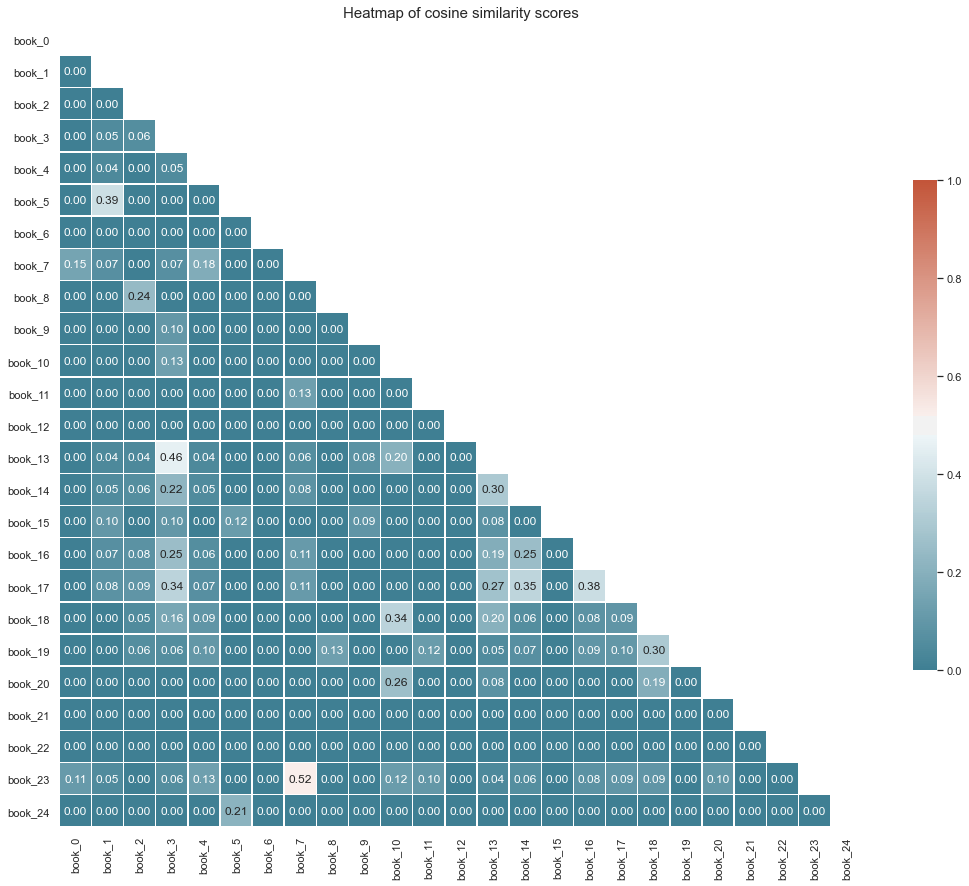

In [31]:
# initialize an empty dataframe grid based on the length of book titles
df_hm = pd.DataFrame({'ind': range(len(book_titles)), 'cols': range(len(book_titles)), 'vals': pd.Series(np.zeros(len(book_titles)))})

# convert to a matrix for the heatmap
df_hm = df_hm.pivot(index='ind', columns='cols').fillna(0)

# make a copy
df_temp = df.copy()

# convert list of tuples into 2 lists
list1 = []
list2 = []
for item1, item2 in df_temp.pair:
    list1.append(item1)
    list2.append(item2)

# add two columns to df_temp
df_temp['book1'] = list1
df_temp['book2'] = list2

# drop the pair as it not needed
df_temp.drop('pair', axis=1, inplace=True)

# extract index so that you can construct pairs
df_temp['book1'] = df_temp['book1'].apply(lambda x: int(x.split('_')[-1]))
df_temp['book2'] = df_temp['book2'].apply(lambda x: int(x.split('_')[-1]))

# create tuples (0, 1, similarity)
df_temp['pairs'] = list(zip(df_temp.book1, df_temp.book2, round(df_temp.similarity, 2)))

# to get lower diagonal, swap the rows and cols.
for row, col, similarity in df_temp.pairs:
    df_hm.iloc[col, row] = similarity

ax = plot_heatmap(df_hm, book_ids, book_ids)

***Which two titles are the most similar to each other? Which are the most dissimilar? Where do they rank, among the first 24 results?***

Book 7 and book 23 had the highest cosine similarity scores


#### 2.	Now evaluate using a major search engine.
- Enter one of the book titles from question 1a into Google, Bing, or Yahoo!. Copy the capsule of the first organic result and the 20th organic result. Take web results only (i.e., not video results), and skip sponsored results. 
- Run the same text similarity calculation that you used for question 1b on each of these capsules in comparison to the original query (book title). 
- Which one has the highest similarity measure? 
 
Submit all of your inputs and outputs and your code for this assignment, along with a brief written explanation of your findings. 



Using the book title: "What If?: Serious Scientific Answers to Absurd Hypothetical Questions" in a google search results in the following first and 20th entry:

1 - What If?: Serious Scientific Answers to Absurd ... - Amazon.comwww.amazon.com › What-If-Scientific-Hypothetical-Q...
What If?: Serious Scientific Answers to Absurd Hypothetical Questions Kindle Edition. by ...

20 - 
What If?: Serious Scientific Answers to Absurd Hypothetical ...books.google.com › books › about › What_If
Title, What If?: Serious Scientific Answers to Absurd Hypothetical Questions. Author, Randall Munroe. Edition, illustrated. Publisher, John Murray, an Hachette ...

In [9]:
# Compare the first search entry to the book
search1 = "What If?: Serious Scientific Answers to Absurd ... - Amazon.comwww.amazon.com › What-If-Scientific-Hypothetical-Q... What If?: Serious Scientific Answers to Absurd Hypothetical Questions Kindle Edition. by ..."
#search20 = "What If?: Serious Scientific Answers to Absurd Hypothetical ...books.google.com › books › about › What_If Title, What If?: Serious Scientific Answers to Absurd Hypothetical Questions. Author, Randall Munroe. Edition, illustrated. Publisher, John Murray, an Hachette ..."
book = "What If?: Serious Scientific Answers to Absurd Hypothetical Questions"

search_list = [search1,book]

# build generic listing of books so we can build out a dictionary
searchID_vals = ["search_" + str(i) for i in range(len(search_list))]

# create a dictionary of the values
search_dict = dict(zip(searchID_vals, search_list))

# grab all of the ids in the list so we can do pairwise comparison
search_ids = list(search_dict.keys())

# create a listing of all possible pairs
# we want to filter out any self-compares and any duplicate comparisons
search_pairs = []

for i, v in enumerate(search_ids):
    for j in search_ids[i+1:]:
        search_pairs.append((search_ids[i],j))

# Look at our search pairs to see if they make sense
print("Total search pairs: ", str(len(search_pairs)))

Total search pairs:  1


In [10]:
# clean the list of book to make them consistent
# cleanTextBooks returns a list of lists
clean_search = cleanTextBooks(search_list)

# convert the list of lists to a list of strings
norm_clean_search = [' '.join(text) for text in clean_search]

print(norm_clean_search)

['serious scientific answer absurd amazoncomwwwamazoncom whatifscientifichypotheticalq serious scientific answer absurd hypothetical question kindle edition', 'serious scientific answer absurd hypothetical question']


In [11]:
vectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,1))

# calculate the feature matrix
feature_matrix = vectorizer.fit_transform(norm_clean_search).astype(float)

# display the shape of feature matrix
display(feature_matrix.shape)

# display the first feature vector
display(feature_matrix[0])

# display the dense version of the feature vector
display(feature_matrix.toarray()[0])

# display the shape of dense feature vector
display(feature_matrix.toarray()[0].shape)

# display the first document text
display(norm_clean_books[0])

(2, 10)

<1x10 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

array([0.39297867, 0.2761589 , 0.39297867, 0.2761589 , 0.19648933,
       0.2761589 , 0.19648933, 0.39297867, 0.39297867, 0.2761589 ])

(10,)

'true fact sound like bullst insanebuttrue fact shock impress friend'

In [22]:
# compute the pairwise cosine similarity for each pair to book titles
pairwise_cosine_similarity = [compute_cosine_similarity(pair) for pair in search_pairs]

# create a dataframe and display the head and tail to make sure everyting is captured
df = pd.DataFrame({'pair': search_pairs, 'similarity': pairwise_cosine_similarity})
display(df.head())
display(df.tail())

NameError: name 'search_pairs' is not defined

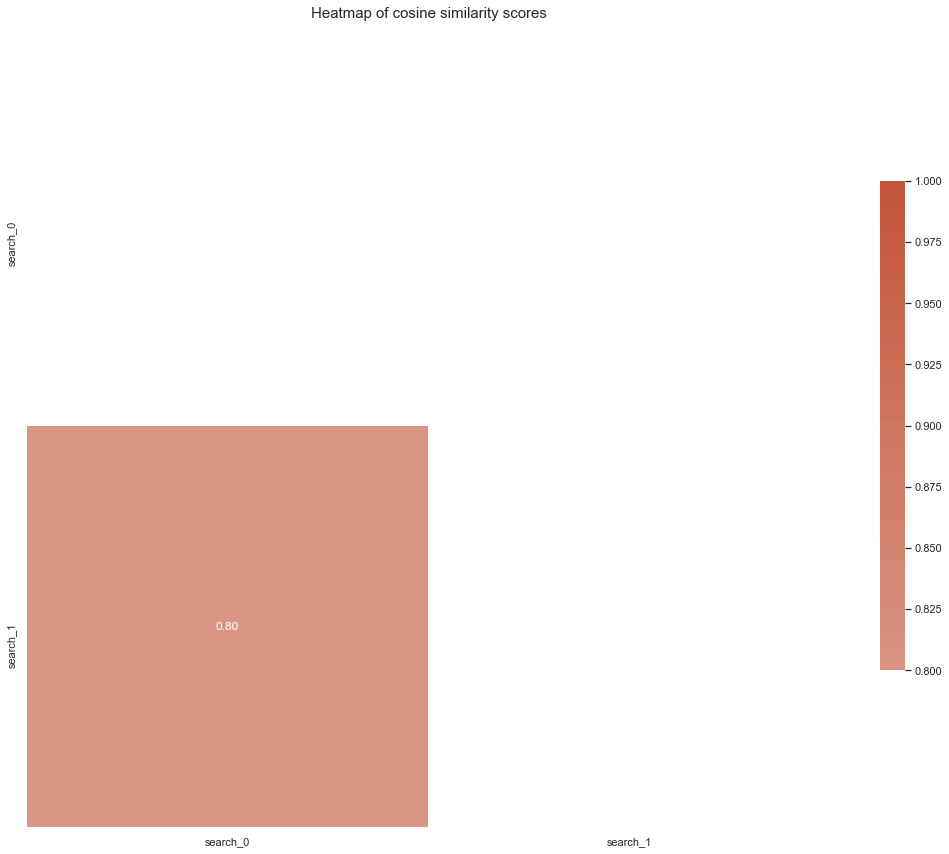

In [13]:
# initialize an empty dataframe grid based on the length of book titles
df_hm = pd.DataFrame({'ind': range(len(search_list)), 'cols': range(len(search_list)), 'vals': pd.Series(np.zeros(len(search_list)))})

# convert to a matrix for the heatmap
df_hm = df_hm.pivot(index='ind', columns='cols').fillna(0)

# make a copy
df_temp = df.copy()

# convert list of tuples into 2 lists
list1 = []
list2 = []
for item1, item2 in df_temp.pair:
    list1.append(item1)
    list2.append(item2)

# add two columns to df_temp
df_temp['search1'] = list1
df_temp['search2'] = list2

# drop the pair as it not needed
df_temp.drop('pair', axis=1, inplace=True)

# extract index so that you can construct pairs
df_temp['search1'] = df_temp['search1'].apply(lambda x: int(x.split('_')[-1]))
df_temp['search2'] = df_temp['search2'].apply(lambda x: int(x.split('_')[-1]))

# create tuples (0, 1, similarity)
df_temp['pairs'] = list(zip(df_temp.search1, df_temp.search2, round(df_temp.similarity, 2)))

# to get lower diagonal, swap the rows and cols.
for row, col, similarity in df_temp.pairs:
    df_hm.iloc[col, row] = similarity

ax = plot_heatmap(df_hm, search_ids, search_ids)

From the above heatmap we see that search 1 and the book title have a 0.80 cosine similarity

In [14]:
# Compare the 20th search entry to the book
#search1 = "What If?: Serious Scientific Answers to Absurd ... - Amazon.comwww.amazon.com › What-If-Scientific-Hypothetical-Q... What If?: Serious Scientific Answers to Absurd Hypothetical Questions Kindle Edition. by ..."
search20 = "What If?: Serious Scientific Answers to Absurd Hypothetical ...books.google.com › books › about › What_If Title, What If?: Serious Scientific Answers to Absurd Hypothetical Questions. Author, Randall Munroe. Edition, illustrated. Publisher, John Murray, an Hachette ..."
book = "What If?: Serious Scientific Answers to Absurd Hypothetical Questions"

search_list = [search20,book]

# build generic listing of books so we can build out a dictionary
searchID_vals = ["search_" + str(i) for i in range(len(search_list))]

# create a dictionary of the values
search_dict = dict(zip(searchID_vals, search_list))

# grab all of the ids in the list so we can do pairwise comparison
search_ids = list(search_dict.keys())

# create a listing of all possible pairs
# we want to filter out any self-compares and any duplicate comparisons
search_pairs = []

for i, v in enumerate(search_ids):
    for j in search_ids[i+1:]:
        search_pairs.append((search_ids[i],j))

# Look at our search pairs to see if they make sense
print("Total search pairs: ", str(len(search_pairs)))

Total search pairs:  1


In [15]:
# clean the list of book to make them consistent
# cleanTextBooks returns a list of lists
clean_search = cleanTextBooks(search_list)

# convert the list of lists to a list of strings
norm_clean_search = [' '.join(text) for text in clean_search]

print(norm_clean_search)

['serious scientific answer absurd hypothetical booksgooglecom book whatif title serious scientific answer absurd hypothetical question author randall munroe edition illustrated publisher john murray hachette', 'serious scientific answer absurd hypothetical question']


In [16]:
vectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,1))

# calculate the feature matrix
feature_matrix = vectorizer.fit_transform(norm_clean_search).astype(float)

# display the shape of feature matrix
display(feature_matrix.shape)

# display the first feature vector
display(feature_matrix[0])

# display the dense version of the feature vector
display(feature_matrix.toarray()[0])

# display the shape of dense feature vector
display(feature_matrix.toarray()[0].shape)

# display the first document text
display(norm_clean_books[0])

(2, 19)

<1x19 sparse matrix of type '<class 'numpy.float64'>'
	with 19 stored elements in Compressed Sparse Row format>

array([0.29273034, 0.29273034, 0.20571114, 0.20571114, 0.20571114,
       0.20571114, 0.20571114, 0.29273034, 0.20571114, 0.20571114,
       0.20571114, 0.20571114, 0.20571114, 0.14636517, 0.20571114,
       0.29273034, 0.29273034, 0.20571114, 0.20571114])

(19,)

'true fact sound like bullst insanebuttrue fact shock impress friend'

In [17]:
# compute the pairwise cosine similarity for each pair to book titles
pairwise_cosine_similarity = [compute_cosine_similarity(pair) for pair in search_pairs]

# create a dataframe and display the head and tail to make sure everyting is captured
df = pd.DataFrame({'pair': search_pairs, 'similarity': pairwise_cosine_similarity})
display(df.head())
display(df.tail())

,pair,similarity
0,"(search_0, search_1)",0.657287


,pair,similarity
0,"(search_0, search_1)",0.657287


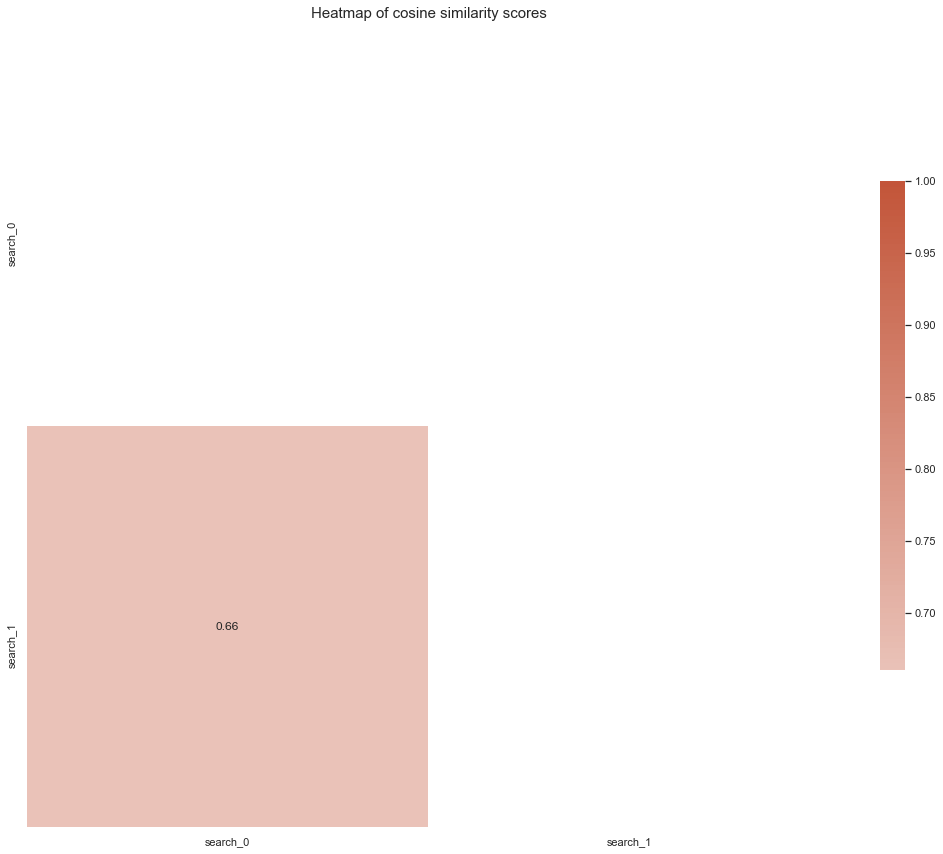

In [18]:
# initialize an empty dataframe grid based on the length of book titles
df_hm = pd.DataFrame({'ind': range(len(search_list)), 'cols': range(len(search_list)), 'vals': pd.Series(np.zeros(len(search_list)))})

# convert to a matrix for the heatmap
df_hm = df_hm.pivot(index='ind', columns='cols').fillna(0)

# make a copy
df_temp = df.copy()

# convert list of tuples into 2 lists
list1 = []
list2 = []
for item1, item2 in df_temp.pair:
    list1.append(item1)
    list2.append(item2)

# add two columns to df_temp
df_temp['search1'] = list1
df_temp['search2'] = list2

# drop the pair as it not needed
df_temp.drop('pair', axis=1, inplace=True)

# extract index so that you can construct pairs
df_temp['search1'] = df_temp['search1'].apply(lambda x: int(x.split('_')[-1]))
df_temp['search2'] = df_temp['search2'].apply(lambda x: int(x.split('_')[-1]))

# create tuples (0, 1, similarity)
df_temp['pairs'] = list(zip(df_temp.search1, df_temp.search2, round(df_temp.similarity, 2)))

# to get lower diagonal, swap the rows and cols.
for row, col, similarity in df_temp.pairs:
    df_hm.iloc[col, row] = similarity

ax = plot_heatmap(df_hm, search_ids, search_ids)

From the above heatmap we can see that the cosine similarity between the book and the 20th search is 0.66.

In [19]:
# Compare the 20th search entry to the first search entry
search1 = "What If?: Serious Scientific Answers to Absurd ... - Amazon.comwww.amazon.com › What-If-Scientific-Hypothetical-Q... What If?: Serious Scientific Answers to Absurd Hypothetical Questions Kindle Edition. by ..."
search20 = "What If?: Serious Scientific Answers to Absurd Hypothetical ...books.google.com › books › about › What_If Title, What If?: Serious Scientific Answers to Absurd Hypothetical Questions. Author, Randall Munroe. Edition, illustrated. Publisher, John Murray, an Hachette ..."
#book = "What If?: Serious Scientific Answers to Absurd Hypothetical Questions"

search_list = [search1,search20]

# build generic listing of books so we can build out a dictionary
searchID_vals = ["search_" + str(i) for i in range(len(search_list))]

# create a dictionary of the values
search_dict = dict(zip(searchID_vals, search_list))

# grab all of the ids in the list so we can do pairwise comparison
search_ids = list(search_dict.keys())

# create a listing of all possible pairs
# we want to filter out any self-compares and any duplicate comparisons
search_pairs = []

for i, v in enumerate(search_ids):
    for j in search_ids[i+1:]:
        search_pairs.append((search_ids[i],j))

# Look at our search pairs to see if they make sense
print("Total search pairs: ", str(len(search_pairs)))

Total search pairs:  1


In [20]:
# clean the list of book to make them consistent
# cleanTextBooks returns a list of lists
clean_search = cleanTextBooks(search_list)

# convert the list of lists to a list of strings
norm_clean_search = [' '.join(text) for text in clean_search]

print(norm_clean_search)

['serious scientific answer absurd amazoncomwwwamazoncom whatifscientifichypotheticalq serious scientific answer absurd hypothetical question kindle edition', 'serious scientific answer absurd hypothetical booksgooglecom book whatif title serious scientific answer absurd hypothetical question author randall munroe edition illustrated publisher john murray hachette']


In [21]:
vectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,1))

# calculate the feature matrix
feature_matrix = vectorizer.fit_transform(norm_clean_search).astype(float)

# display the shape of feature matrix
display(feature_matrix.shape)

# display the first feature vector
display(feature_matrix[0])

# display the dense version of the feature vector
display(feature_matrix.toarray()[0])

# display the shape of dense feature vector
display(feature_matrix.toarray()[0].shape)

# display the first document text
display(norm_clean_books[0])

(2, 22)

<1x22 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

array([0.40059335, 0.28150998, 0.40059335, 0.        , 0.        ,
       0.        , 0.20029667, 0.        , 0.20029667, 0.        ,
       0.        , 0.28150998, 0.        , 0.        , 0.        ,
       0.20029667, 0.        , 0.40059335, 0.40059335, 0.        ,
       0.        , 0.28150998])

(22,)

'true fact sound like bullst insanebuttrue fact shock impress friend'

In [22]:
# compute the pairwise cosine similarity for each pair to book titles
pairwise_cosine_similarity = [compute_cosine_similarity(pair) for pair in search_pairs]

# create a dataframe and display the head and tail to make sure everyting is captured
df = pd.DataFrame({'pair': search_pairs, 'similarity': pairwise_cosine_similarity})
display(df.head())
display(df.tail())

,pair,similarity
0,"(search_0, search_1)",0.592552


,pair,similarity
0,"(search_0, search_1)",0.592552


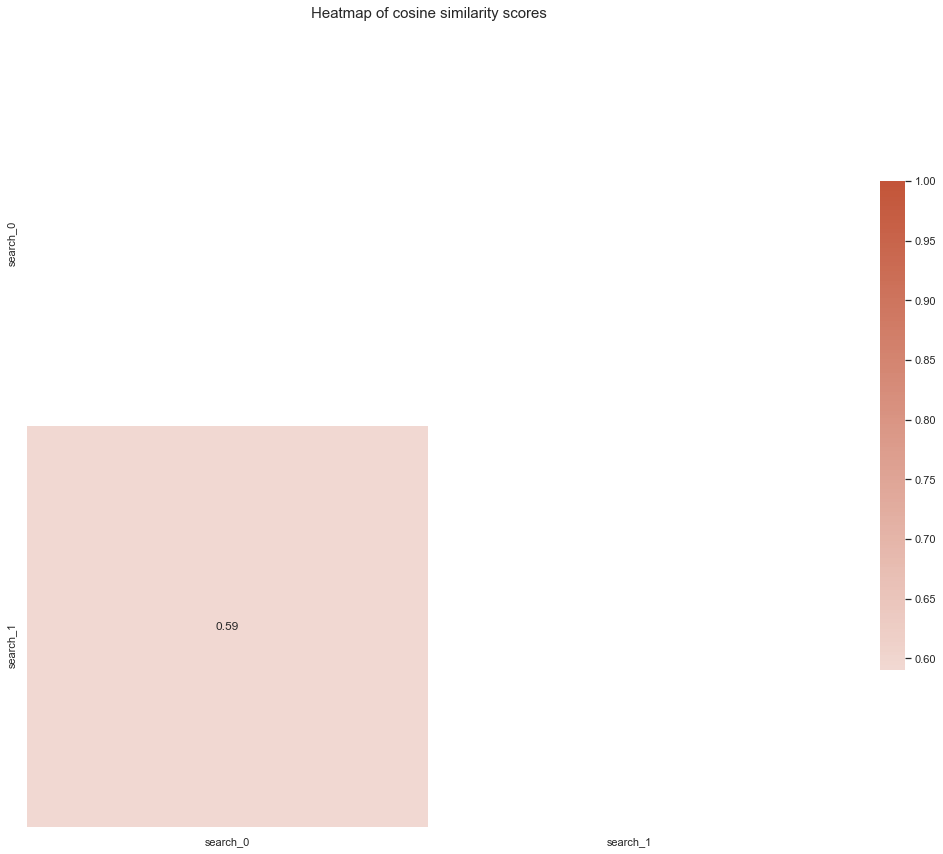

In [23]:
# initialize an empty dataframe grid based on the length of book titles
df_hm = pd.DataFrame({'ind': range(len(search_list)), 'cols': range(len(search_list)), 'vals': pd.Series(np.zeros(len(search_list)))})

# convert to a matrix for the heatmap
df_hm = df_hm.pivot(index='ind', columns='cols').fillna(0)

# make a copy
df_temp = df.copy()

# convert list of tuples into 2 lists
list1 = []
list2 = []
for item1, item2 in df_temp.pair:
    list1.append(item1)
    list2.append(item2)

# add two columns to df_temp
df_temp['search1'] = list1
df_temp['search2'] = list2

# drop the pair as it not needed
df_temp.drop('pair', axis=1, inplace=True)

# extract index so that you can construct pairs
df_temp['search1'] = df_temp['search1'].apply(lambda x: int(x.split('_')[-1]))
df_temp['search2'] = df_temp['search2'].apply(lambda x: int(x.split('_')[-1]))

# create tuples (0, 1, similarity)
df_temp['pairs'] = list(zip(df_temp.search1, df_temp.search2, round(df_temp.similarity, 2)))

# to get lower diagonal, swap the rows and cols.
for row, col, similarity in df_temp.pairs:
    df_hm.iloc[col, row] = similarity

ax = plot_heatmap(df_hm, search_ids, search_ids)

From the heatmap above we can see the the two search strings only have a 0.59 cosine similarity

### Question 2 Analysis:

Using the heatmaps and calculations above we can see that the first google search entry for the book "What If?: Serious Scientific Answers to Absurd Hypothetical Questions" had a cosine similarity of 0.80. Given that the first search entry was the actual listing at Amazon this logically makes sense. The 20th entry and the book have a cosine similarity of 0.66. This 20th result was a Google link result. In comparison to the first entry this similary score makes sense give that it's close to the book but not as close as the original link. The other interesting aspect of the analysis is the comparison between the two search strings. The two strings only have a 0.59 cosine similarity. The strings are similiar but not as similar to each other as they are to the book. We would expect this result as the differnent search entries contain different information. 